# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

F&B is one of the industry growing fasted in Vietnam. More and more people would like to start with a restaurant or coffee shop, even a food chain. However, they may be confused when making a decision related to most profited place for their restaurants.

In this project I will try to find an optimal location for a restaurant, the solutions which is beneficial to people who want to start in F&B industry. Specifically, this report will be targeted to stakeholders interested in opening a restaurant in the center of our capital - **Hoan Kiem District, Hanoi**, Vietnam. 

Since there are lots of restaurants in Hanoi I will try to detect **locations that are not already crowded with restaurants**.

I will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## 2. Data <a name="data"></a>

Based on definition of the problem, factors that will influence the decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* Detail information of neighborhoods in Hoan Kiem District, list of districts, wards of Dong Da district, Ha Noi from the following URL https://www.gso.gov.vn/dmhc2015/Default.aspx or file data xls from the following https://github.com/thuthuyftu49/Coursera_Capstone/blob/master/HoanKiem_District.xls

**Google map API**

This project would use Google Map API Geocoder to get the Latitude and Longitude of each area

**Foursquare API**

This project would use Four-square API as its prime data gathering source. This API provides the ability to perform location search, location sharing and details about a business.

### 2.1. Install packages

In [18]:
!pip install lxml
!pip install bs4
!pip install Nominatim
!pip install geopy
!pip install geocoder
!pip install xlrd
!pip install folium

### 2.2. Load necessary library

In [19]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import lxml
import folium # map rendering library

import pandas as pd
import lxml
import xlrd

print("Libraries imported.")

Libraries imported.


### 2.3. Load file excel districts, wards of VietNam

In [24]:
df=pd.read_csv('https://raw.githubusercontent.com/thuthuyftu49/Coursera_Capstone/master/HoanKiem_District.csv')
df.head()

,Tỉnh Thành Phố,Mã TP,Quận Huyện,Mã QH,Phường Xã,Mã PX,Cấp,Tên Tiếng Anh
0,Thành phố Hà Nội,1,Quận Hoàn Kiếm,2,Phường Phúc Tân,37,Phường,NaN
1,Thành phố Hà Nội,1,Quận Hoàn Kiếm,2,Phường Đồng Xuân,40,Phường,NaN
2,Thành phố Hà Nội,1,Quận Hoàn Kiếm,2,Phường Hàng Mã,43,Phường,NaN
3,Thành phố Hà Nội,1,Quận Hoàn Kiếm,2,Phường Hàng Buồm,46,Phường,NaN
4,Thành phố Hà Nội,1,Quận Hoàn Kiếm,2,Phường Hàng Đào,49,Phường,NaN


In [26]:
df['area'] = df['Phường Xã']+', '+df['Quận Huyện']+', Hà Nội'

df_hoankiem_district=df[['Phường Xã','Quận Huyện','area']]
df_hoankiem_district.columns = ['ward','district','area']
df_hoankiem_district.head(10)

,ward,district,area
0,Phường Phúc Tân,Quận Hoàn Kiếm,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội"
1,Phường Đồng Xuân,Quận Hoàn Kiếm,"Phường Đồng Xuân, Quận Hoàn Kiếm, Hà Nội"
2,Phường Hàng Mã,Quận Hoàn Kiếm,"Phường Hàng Mã, Quận Hoàn Kiếm, Hà Nội"
3,Phường Hàng Buồm,Quận Hoàn Kiếm,"Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội"
4,Phường Hàng Đào,Quận Hoàn Kiếm,"Phường Hàng Đào, Quận Hoàn Kiếm, Hà Nội"
5,Phường Hàng Bồ,Quận Hoàn Kiếm,"Phường Hàng Bồ, Quận Hoàn Kiếm, Hà Nội"
6,Phường Cửa Đông,Quận Hoàn Kiếm,"Phường Cửa Đông, Quận Hoàn Kiếm, Hà Nội"
7,Phường Lý Thái Tổ,Quận Hoàn Kiếm,"Phường Lý Thái Tổ, Quận Hoàn Kiếm, Hà Nội"
8,Phường Hàng Bạc,Quận Hoàn Kiếm,"Phường Hàng Bạc, Quận Hoàn Kiếm, Hà Nội"
9,Phường Hàng Gai,Quận Hoàn Kiếm,"Phường Hàng Gai, Quận Hoàn Kiếm, Hà Nội"


In [28]:
df_hoankiem_district.shape

(18, 3)

In [29]:
df_hoankiem_district.to_csv('VN_HN_HOANKIEM_DISTRICT.csv',index=False)

### 2.4. Add latitude, longitude by call Google Geocode API

In [30]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Malaysia'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [31]:
coords = [ get_latlng(neighborhood) for neighborhood in df_hoankiem_district["area"].tolist() ]

In [32]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_hoankiem_district_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [33]:
df_hoankiem_district_coords.head()

,Latitude,Longitude
0,21.03703,105.85480
1,21.03880,105.84987
2,21.03969,105.84674
3,21.03604,105.85243
4,21.03403,105.85030


In [34]:
# merge the coordinates into the original dataframe
df_hoankiem_district_new =pd.concat([df_hoankiem_district, df_hoankiem_district_coords], axis=1)
df_hoankiem_district_new.head()

,ward,district,area,Latitude,Longitude
0,Phường Phúc Tân,Quận Hoàn Kiếm,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.85480
1,Phường Đồng Xuân,Quận Hoàn Kiếm,"Phường Đồng Xuân, Quận Hoàn Kiếm, Hà Nội",21.03880,105.84987
2,Phường Hàng Mã,Quận Hoàn Kiếm,"Phường Hàng Mã, Quận Hoàn Kiếm, Hà Nội",21.03969,105.84674
3,Phường Hàng Buồm,Quận Hoàn Kiếm,"Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội",21.03604,105.85243
4,Phường Hàng Đào,Quận Hoàn Kiếm,"Phường Hàng Đào, Quận Hoàn Kiếm, Hà Nội",21.03403,105.85030


In [35]:
# save the DataFrame as CSV file
df_hoankiem_district_new.to_csv("VN_HN_HOANKIEM_DISTRICT_LATLONG", index=False)

### 2.5. Create a map of Hoan Kiem district's Hanoi with neighborhoods superimposed on top

In [36]:
address='Hoàn Kiếm, Hà Nội, Việt Nam'
geolocator = Nominatim(user_agent="HaNoi")

location = geolocator.geocode(address)
lat_HN=location.latitude
long_HN =location.longitude
print('The geograpical coodinate of Hoan Kiem District, HaNoi are {},{}.'.format(lat_HN,long_HN))

The geograpical coodinate of Hoan Kiem District, HaNoi are 21.0289343,105.8522605.


In [37]:
map_HN = folium.Map(location=[lat_HN, long_HN], zoom_start=13)

# add markers to map
for lat, lng, Neighbourhood in zip(df_hoankiem_district_new['Latitude'], df_hoankiem_district_new['Longitude'], df_hoankiem_district_new['ward']):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_HN)  
    
map_HN

In [38]:
# save the map as HTML file
map_HN.save('map_HN.html')

### 2.6. Use the Foursquare API to explore the neighborhoods

In [39]:
# define Foursquare Credentials and Version
CLIENT_ID = '41TZ0AFJOJYAQ203YFPH3FHBCH1GMVHG05GO3MUVUBFH1ERM' 
CLIENT_SECRET = 'OEUT5WRSLNR5MVFEXTJUASGBCRS0SVDSP1FM0K3BYHVLM1BK' 
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 41TZ0AFJOJYAQ203YFPH3FHBCH1GMVHG05GO3MUVUBFH1ERM
CLIENT_SECRET:OEUT5WRSLNR5MVFEXTJUASGBCRS0SVDSP1FM0K3BYHVLM1BK


In [40]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

In [41]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
Hanoi_venues=getNearbyVenues(names=df_hoankiem_district_new['area'],
                               latitudes=df_hoankiem_district_new['Latitude'],
                               longitudes=df_hoankiem_district_new['Longitude'],
                              )

Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội
Phường Đồng Xuân, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Mã, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Đào, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Bồ, Quận Hoàn Kiếm, Hà Nội
Phường Cửa Đông, Quận Hoàn Kiếm, Hà Nội
Phường Lý Thái Tổ, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Bạc, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Gai, Quận Hoàn Kiếm, Hà Nội
Phường Chương Dương, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Trống, Quận Hoàn Kiếm, Hà Nội
Phường Cửa Nam, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Bông, Quận Hoàn Kiếm, Hà Nội
Phường Tràng Tiền, Quận Hoàn Kiếm, Hà Nội
Phường Trần Hưng Đạo, Quận Hoàn Kiếm, Hà Nội
Phường Phan Chu Trinh, Quận Hoàn Kiếm, Hà Nội
Phường Hàng Bài, Quận Hoàn Kiếm, Hà Nội


In [43]:
Hanoi_venues.shape

(1073, 7)

In [45]:
Hanoi_venues.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,Cộng Càphê,21.035166,105.853395,Coffee Shop
1,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,La Siesta Hotel,21.034275,105.853351,Hotel
2,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,Bun Cha Ta,21.034373,105.854382,Noodle House
3,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,Medallion Hotel,21.036051,105.853257,Hotel
4,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,The Veg,21.035526,105.853580,Vegetarian / Vegan Restaurant
5,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,Blue Butterfly,21.034723,105.853485,Vietnamese Restaurant
6,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,Central Backpackers - Old Quater,21.037664,105.851959,Hostel
7,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,Duong's 2 Restaurant & Cooking Class,21.034108,105.853497,Vietnamese Restaurant
8,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,Orchid Cooking Class & Restaurant,21.033874,105.853270,Vietnamese Restaurant
9,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.8548,Bánh Mỳ P,21.035898,105.852515,Sandwich Place


In [46]:
Hanoi_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Phường Chương Dương, Quận Hoàn Kiếm, Hà Nội",11,11,11,11,11,11
"Phường Cửa Nam, Quận Hoàn Kiếm, Hà Nội",58,58,58,58,58,58
"Phường Cửa Đông, Quận Hoàn Kiếm, Hà Nội",67,67,67,67,67,67
"Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội",92,92,92,92,92,92
"Phường Hàng Bài, Quận Hoàn Kiếm, Hà Nội",79,79,79,79,79,79
"Phường Hàng Bông, Quận Hoàn Kiếm, Hà Nội",56,56,56,56,56,56
"Phường Hàng Bạc, Quận Hoàn Kiếm, Hà Nội",100,100,100,100,100,100
"Phường Hàng Bồ, Quận Hoàn Kiếm, Hà Nội",51,51,51,51,51,51
"Phường Hàng Gai, Quận Hoàn Kiếm, Hà Nội",100,100,100,100,100,100


In [47]:
print('There are {} uniques categories.'.format(len(Hanoi_venues['Venue Category'].unique())))

There are 89 uniques categories.


In [48]:
# print out the list of categories
Hanoi_venues['Venue Category'].unique()[:50]

array(['Coffee Shop', 'Hotel', 'Noodle House',
       'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant', 'Hostel',
       'Sandwich Place', 'Gastropub', 'French Restaurant', 'Burger Joint',
       'Beer Garden', 'Café', 'Lounge', 'Pub', 'Cafeteria',
       'Ice Cream Shop', 'Restaurant', 'Taco Place', 'Dessert Shop',
       'Spa', 'Historic Site', 'Tibetan Restaurant', 'Food',
       'Dairy Store', 'Tea Room', 'Cocktail Bar', 'Market',
       'Czech Restaurant', 'Bakery', 'Candy Store', 'Nightclub',
       'Train Station', 'Asian Restaurant', 'Pizza Place',
       'Arts & Crafts Store', 'Massage Studio', 'Temple', 'Juice Bar',
       'Bistro', 'Hotpot Restaurant', 'BBQ Joint', 'Jewelry Store',
       'Mobile Phone Shop', 'Hotel Bar', 'Italian Restaurant',
       'Cultural Center', 'Halal Restaurant', 'Steakhouse', 'Park',
       'Fast Food Restaurant'], dtype=object)

#### Check how many venues were returned for each neighborhood

In [49]:
HN_HoanKiem_venues = Hanoi_venues.groupby('Venue Category').count()

In [50]:
HN_HoanKiem_venues = HN_HoanKiem_venues.reindex(columns=['Neighbourhood'])
HN_HoanKiem_venues = HN_HoanKiem_venues.sort_values(by=['Neighbourhood'], ascending=False).head(20)
HN_HoanKiem_venues.to_csv('HN_HoanKiem_venues.csv')

#### Draw char

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
HN_venues_bar = pd.read_csv('HN_HoanKiem_venues.csv')

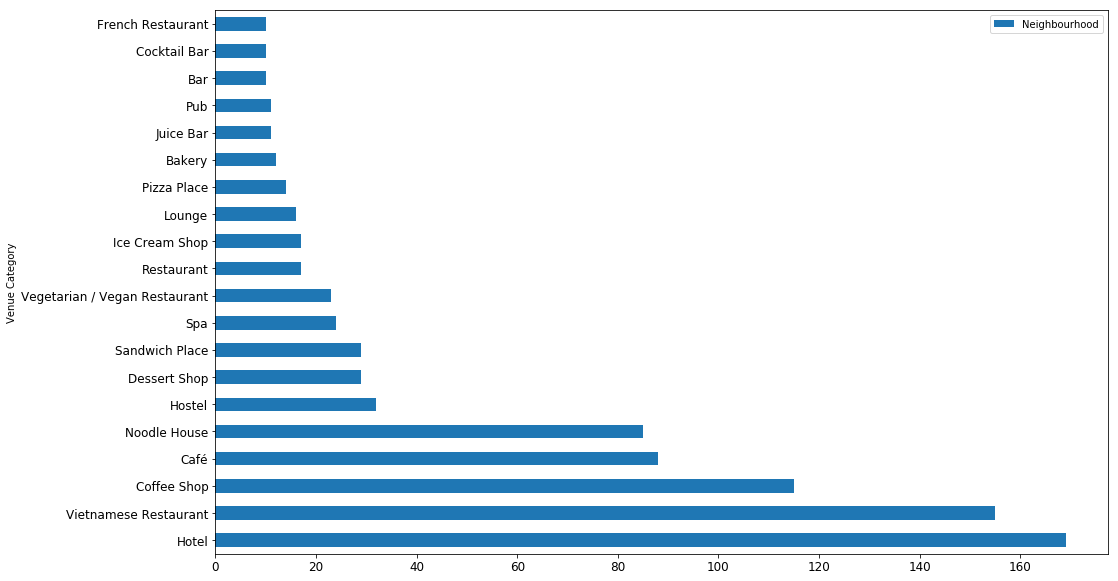

In [52]:
HN_venues_bar.plot.barh(x='Venue Category',fontsize = 12, figsize=(16, 10),stacked=True);

In [53]:
# one hot encoding
hn_onehot = pd.get_dummies(Hanoi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hn_onehot['Neighbourhood'] = Hanoi_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [hn_onehot.columns[-1]] + list(hn_onehot.columns[:-1])
hn_onehot.head()

,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Ballroom,Bar,Beer Garden,Belgian Restaurant,Bistro,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Cafeteria,Café,Canal,Candy Store,Chocolate Shop,Cocktail Bar,Coffee Shop,Comic Shop,Creperie,Cultural Center,Czech Restaurant,Dairy Store,Dessert Shop,Dim Sum Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Food,Food Truck,French Restaurant,Frozen Yogurt Shop,Gastropub,German Restaurant,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Museum,Nightclub,Noodle House,Opera House,Park,Pizza Place,Pool,Pub,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shawarma Place,Soup Place,Spa,Spanish Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Temple,Tibetan Restaurant,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội"
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội"
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội"
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội"
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội"


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [54]:
HN_grouped=hn_onehot.groupby('Neighbourhood').mean().reset_index()
HN_grouped

,Neighbourhood,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Ballroom,Bar,Beer Garden,Belgian Restaurant,Bistro,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Cafeteria,Café,Canal,Candy Store,Chocolate Shop,Cocktail Bar,Coffee Shop,Comic Shop,Creperie,Cultural Center,Czech Restaurant,Dairy Store,Dessert Shop,Dim Sum Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Food,Food Truck,French Restaurant,Frozen Yogurt Shop,Gastropub,German Restaurant,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Museum,Nightclub,Noodle House,Opera House,Park,Pizza Place,Pool,Pub,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shawarma Place,Soup Place,Spa,Spanish Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Temple,Tibetan Restaurant,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,"Phường Chương Dương, Quận Hoàn Kiếm, Hà Nội",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272727,0.000000,0.00000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.181818,0.000000
1,"Phường Cửa Nam, Quận Hoàn Kiếm, Hà Nội",0.000000,0.000000,0.000000,0.017241,0.051724,0.000000,0.034483,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.103448,0.000000,0.00000,0.017241,0.017241,0.103448,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.017241,0.017241,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.137931,0.000000,0.017241,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.034483,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.034483,0.172414,0.000000
2,"Phường Cửa Đông, Quận Hoàn Kiếm, Hà Nội",0.000000,0.014925,0.000000,0.014925,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925,0.000000,0.000000,0.000000,0.000000,0.000000,0.119403,0.000000,0.00000,0.000000,0.014925,0.089552,0.000000,0.000000,0.000000,0.000000,0.000000,0.044776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029851,0.208955,0.000000,0.014925,0.000000,0.000000,0.000000,0.000000,0.014925,0.014925,0.000000,0.000000,0.000000,0.000000,0.029851,0.014925,0.000000,0.000000,0.000000,0.000000,0.000000,0.134328,0.000000,0.000000,0.029851,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925,0.000000,0.000000,0.000000,0.029851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.014925,0.134328,0.000000
3,"Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội",0.000000,0.000000,0.000000,0.000000,0.010870,0.000000,0.000000,0.010870,0.000000,0.000000,0.000000,0.000000,0.010870,0.000000,0.010870,0.043478,0.000000,0.01087,0.000000,0.010870,0.108696,0.000000,0.000000,0.000000,0.000000,0.010870,0.032609,

#### Print each neighborhood along with the top 5 most common venues

In [55]:
num_top_venues = 5


for hood in HN_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = HN_grouped[HN_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Phường Chương Dương, Quận Hoàn Kiếm, Hà Nội----
                   venue  freq
0                   Café  0.27
1  Vietnamese Restaurant  0.18
2     Italian Restaurant  0.09
3                  Hotel  0.09
4              Nightclub  0.09


----Phường Cửa Nam, Quận Hoàn Kiếm, Hà Nội----
                   venue  freq
0  Vietnamese Restaurant  0.17
1                  Hotel  0.14
2            Coffee Shop  0.10
3                   Café  0.10
4                 Bakery  0.05


----Phường Cửa Đông, Quận Hoàn Kiếm, Hà Nội----
                   venue  freq
0                  Hotel  0.21
1  Vietnamese Restaurant  0.13
2           Noodle House  0.13
3                   Café  0.12
4            Coffee Shop  0.09


----Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội----
                   venue  freq
0                  Hotel  0.20
1  Vietnamese Restaurant  0.18
2            Coffee Shop  0.11
3           Noodle House  0.09
4                   Café  0.04


----Phường Hàng Bài, Quận Hoàn Kiếm, Hà Nội----
    

#### Put that into a pandas dataframe

In [56]:
#write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [58]:
#create the new dataframe and display the top 10 venues for each neighborhood
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = HN_grouped['Neighbourhood']

for ind in np.arange(HN_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(HN_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Phường Chương Dương, Quận Hoàn Kiếm, Hà Nội",Café,Vietnamese Restaurant,Nightclub,Seafood Restaurant,Hotel
1,"Phường Cửa Nam, Quận Hoàn Kiếm, Hà Nội",Vietnamese Restaurant,Hotel,Café,Coffee Shop,Bakery
2,"Phường Cửa Đông, Quận Hoàn Kiếm, Hà Nội",Hotel,Noodle House,Vietnamese Restaurant,Café,Coffee Shop
3,"Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội",Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café
4,"Phường Hàng Bài, Quận Hoàn Kiếm, Hà Nội",Coffee Shop,Vietnamese Restaurant,Dessert Shop,Noodle House,Hotel
5,"Phường Hàng Bông, Quận Hoàn Kiếm, Hà Nội",Vietnamese Restaurant,Café,Hotel,Coffee Shop,Noodle House
6,"Phường Hàng Bạc, Quận Hoàn Kiếm, Hà Nội",Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café
7,"Phường Hàng Bồ, Quận Hoàn Kiếm, Hà Nội",Hotel,Noodle House,Hostel,Vietnamese Restaurant,Café
8,"Phường Hàng Gai, Quận Hoàn Kiếm, Hà Nội",Hotel,Vietnamese Restaurant,Noodle House,Coffee Shop,Café
9,"Phường Hàng Mã, Quận Hoàn Kiếm, Hà Nội",Coffee Shop,Vietnamese Restaurant,Spa,Noodle House,Czech Restaurant


## 3. Methodology <a name="methodology"></a>

After data acquisition and cleaning, this project applies K-mean clustering unsupervised machine learning algorithm to cluster the venues based on a list of locations for different types of food and beverage service points such as bars, cafes, Chinese restaurants, Vietnamese restaurants, Seafood restaurants, etc. This would give a better understanding of the similarities and dissimilarities between the chosen neighborhoods to retrieve more insights.

Analyze Each Neighborhood, group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. Next, create the new data frame and display the top 10 venues for each neighborhood.

Then use the Kmean algorithm from the sklearn library to divide it into 5 groups with similar properties. Next, assign labels from Kmean result to each neighborhood using the Pandas merge function.

In [59]:
# set number of clusters
kclusters = 5

hn_grouped_clustering = HN_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 
# to change use .astype()

array([0, 4, 1, 1, 2, 4, 1, 1, 1, 2, 4, 1, 4, 2, 1, 2, 3, 1], dtype=int32)

## 4. Analysis <a name="analysis"></a>

#### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [60]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
neighbourhoods_venues_sorted.head()

,Cluster_Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,"Phường Chương Dương, Quận Hoàn Kiếm, Hà Nội",Café,Vietnamese Restaurant,Nightclub,Seafood Restaurant,Hotel
1,4,"Phường Cửa Nam, Quận Hoàn Kiếm, Hà Nội",Vietnamese Restaurant,Hotel,Café,Coffee Shop,Bakery
2,1,"Phường Cửa Đông, Quận Hoàn Kiếm, Hà Nội",Hotel,Noodle House,Vietnamese Restaurant,Café,Coffee Shop
3,1,"Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội",Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café
4,2,"Phường Hàng Bài, Quận Hoàn Kiếm, Hà Nội",Coffee Shop,Vietnamese Restaurant,Dessert Shop,Noodle House,Hotel


In [61]:
HN_merged = df_hoankiem_district_new

# merge to add latitude/longitude for each neighborhood
HN_merged = HN_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='area')

HN_merged.head() # check the last columns!

,ward,district,area,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Phường Phúc Tân,Quận Hoàn Kiếm,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.85480,1,Vietnamese Restaurant,Hotel,Noodle House,Coffee Shop,Café
1,Phường Đồng Xuân,Quận Hoàn Kiếm,"Phường Đồng Xuân, Quận Hoàn Kiếm, Hà Nội",21.03880,105.84987,1,Hotel,Dessert Shop,Hostel,Vietnamese Restaurant,Noodle House
2,Phường Hàng Mã,Quận Hoàn Kiếm,"Phường Hàng Mã, Quận Hoàn Kiếm, Hà Nội",21.03969,105.84674,2,Coffee Shop,Vietnamese Restaurant,Spa,Noodle House,Czech Restaurant
3,Phường Hàng Buồm,Quận Hoàn Kiếm,"Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội",21.03604,105.85243,1,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café
4,Phường Hàng Đào,Quận Hoàn Kiếm,"Phường Hàng Đào, Quận Hoàn Kiếm, Hà Nội",21.03403,105.85030,1,Vietnamese Restaurant,Hotel,Noodle House,Coffee Shop,Café


In [62]:
HN_merged=HN_merged.dropna()

In [63]:
HN_merged['Cluster_Labels'] = HN_merged.Cluster_Labels.astype(int)
HN_merged.head(10)

,ward,district,area,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Phường Phúc Tân,Quận Hoàn Kiếm,"Phường Phúc Tân, Quận Hoàn Kiếm, Hà Nội",21.03703,105.85480,1,Vietnamese Restaurant,Hotel,Noodle House,Coffee Shop,Café
1,Phường Đồng Xuân,Quận Hoàn Kiếm,"Phường Đồng Xuân, Quận Hoàn Kiếm, Hà Nội",21.03880,105.84987,1,Hotel,Dessert Shop,Hostel,Vietnamese Restaurant,Noodle House
2,Phường Hàng Mã,Quận Hoàn Kiếm,"Phường Hàng Mã, Quận Hoàn Kiếm, Hà Nội",21.03969,105.84674,2,Coffee Shop,Vietnamese Restaurant,Spa,Noodle House,Czech Restaurant
3,Phường Hàng Buồm,Quận Hoàn Kiếm,"Phường Hàng Buồm, Quận Hoàn Kiếm, Hà Nội",21.03604,105.85243,1,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café
4,Phường Hàng Đào,Quận Hoàn Kiếm,"Phường Hàng Đào, Quận Hoàn Kiếm, Hà Nội",21.03403,105.85030,1,Vietnamese Restaurant,Hotel,Noodle House,Coffee Shop,Café
5,Phường Hàng Bồ,Quận Hoàn Kiếm,"Phường Hàng Bồ, Quận Hoàn Kiếm, Hà Nội",21.03516,105.84822,1,Hotel,Noodle House,Hostel,Vietnamese Restaurant,Café
6,Phường Cửa Đông,Quận Hoàn Kiếm,"Phường Cửa Đông, Quận Hoàn Kiếm, Hà Nội",21.03245,105.84542,1,Hotel,Noodle House,Vietnamese Restaurant,Café,Coffee Shop
7,Phường Lý Thái Tổ,Quận Hoàn Kiếm,"Phường Lý Thái Tổ, Quận Hoàn Kiếm, Hà Nội",21.02898,105.85568,4,Hotel,Café,Coffee Shop,Vietnamese Restaurant,Hotel Bar
8,Phường Hàng Bạc,Quận Hoàn Kiếm,"Phường Hàng Bạc, Quận Hoàn Kiếm, Hà Nội",21.03309,105.85231,1,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café
9,Phường Hàng Gai,Quận Hoàn Kiếm,"Phường Hàng Gai, Quận Hoàn Kiếm, Hà Nội",21.03205,105.84869,1,Hotel,Vietnamese Restaurant,Noodle House,Coffee Shop,Café


In [64]:
# create map
map_clusters = folium.Map(location=[lat_HN, long_HN], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(HN_merged['Latitude'], HN_merged['Longitude'], HN_merged['area'], HN_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [65]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

## 5. Results & Discussion <a name="results"></a>

### Cluster 1

In [66]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 0, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Phường Chương Dương,0,Café,Vietnamese Restaurant,Nightclub,Seafood Restaurant,Hotel


### Cluster 2

In [67]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 1, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Phường Phúc Tân,1,Vietnamese Restaurant,Hotel,Noodle House,Coffee Shop,Café
1,Phường Đồng Xuân,1,Hotel,Dessert Shop,Hostel,Vietnamese Restaurant,Noodle House
3,Phường Hàng Buồm,1,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café
4,Phường Hàng Đào,1,Vietnamese Restaurant,Hotel,Noodle House,Coffee Shop,Café
5,Phường Hàng Bồ,1,Hotel,Noodle House,Hostel,Vietnamese Restaurant,Café
6,Phường Cửa Đông,1,Hotel,Noodle House,Vietnamese Restaurant,Café,Coffee Shop
8,Phường Hàng Bạc,1,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café
9,Phường Hàng Gai,1,Hotel,Vietnamese Restaurant,Noodle House,Coffee Shop,Café


### Cluster 3

In [68]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 2, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Phường Hàng Mã,2,Coffee Shop,Vietnamese Restaurant,Spa,Noodle House,Czech Restaurant
14,Phường Tràng Tiền,2,Coffee Shop,Café,Vietnamese Restaurant,Hotel,Hotel Bar
16,Phường Phan Chu Trinh,2,Vietnamese Restaurant,Hotel,Coffee Shop,Restaurant,Hotel Bar
17,Phường Hàng Bài,2,Coffee Shop,Vietnamese Restaurant,Dessert Shop,Noodle House,Hotel


### Cluster 4

In [69]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 3, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Phường Trần Hưng Đạo,3,Hotel,Wine Bar,Supermarket,Noodle House,Cultural Center


### Cluster 5

In [70]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 4, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,Phường Lý Thái Tổ,4,Hotel,Café,Coffee Shop,Vietnamese Restaurant,Hotel Bar
11,Phường Hàng Trống,4,Hotel,Café,Coffee Shop,Noodle House,Vietnamese Restaurant
12,Phường Cửa Nam,4,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Bakery
13,Phường Hàng Bông,4,Vietnamese Restaurant,Café,Hotel,Coffee Shop,Noodle House


In [76]:
print('After reviewing the data of each cluster, I have some discussions:')

print("At Cluster 1, 2 most common venue is Restaurant, so you need to be careful when intending to open a restaurant there. \n Cluster 3, 5 focus mainly on restaurants, Cafe, so you also need to be careful when you intend to open a restaurant there. \n At Cluster 4, there is a noodle house, so you can rest assured that you can open a restaurant without much competition.")

After reviewing the data of each cluster, I have some discussions:
At Cluster 1, 2 most common venue is Restaurant, so you need to be careful when intending to open a restaurant there. 
 Cluster 3, 5 focus mainly on restaurants, Cafe, so you also need to be careful when you intend to open a restaurant there. 
 At Cluster 4, there is a noodle house, so you can rest assured that you can open a restaurant without much competition.


## 6. Conclusion <a name="conclusion"></a>

Finally, I have got a small glimpse of how real-life data-science projects look like. I used various types of APIs to collect data, used the Pandas library to eliminate redundant data, used it, and used Python libraries to draw graphs, using unsupervised machine learning algorithms to group data into similar characteristics. From that it is possible to discover the information that is hidden in it, making it easier to make decisions such as where to open a restaurant is appropriate and less competitive.